In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import time

# Set the device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print('Using device:', device)
# Load the data
path = 'MSFT_2006-01-01_to_2018-01-01.csv'
df = pd.read_csv(path)
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,26.25,27.00,26.10,26.84,79974418,MSFT
1,2006-01-04,26.77,27.08,26.77,26.97,57975661,MSFT
2,2006-01-05,26.96,27.13,26.91,26.99,48247610,MSFT
3,2006-01-06,26.89,27.00,26.49,26.91,100969092,MSFT
4,2006-01-09,26.93,27.07,26.76,26.86,55627836,MSFT


In [ ]:
df.Date = pd.to_datetime(df.Date) # Convert the date to datetime
df = df.set_index('Date') # Set the date as the index for better plotting
df = df.sort_index()

# Plotting Close Price history 
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [36]:
#Data Preprocessing
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

def split_data(stock, lookback):
    data_raw = stock.copy() # convert to numpy array
    data = []
    
    # create all possible sequences of length lookback
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    
    test_set_size = int(np.round(0.20 * data.shape[0]))  # Update test set size to 20%
    train_set_size = data.shape[0] - test_set_size  # Update train set size accordingly
    
    x_train = data[:train_set_size, :, ]
    y_train = data[:train_set_size, -1]  
    
    x_test = data[train_set_size:, :]
    y_test = data[train_set_size:, -1]  
    
    return [x_train, y_train, x_test, y_test]

lookback = 20 # choose sequence length
X_train, y_train, X_test, y_test = split_data(df['Close'].values, lookback)


# Convert the data to PyTorch tensors
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)
#Reshape the data to 3D
X_train = X_train.view([X_train.shape[0], X_train.shape[1], 1])
X_test = X_test.view([X_test.shape[0], X_test.shape[1], 1])
y_train = y_train.view([y_train.shape[0], 1])
y_test = y_test.view([y_test.shape[0], 1])

#Creating Tensor Datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
# Data loaders
batch_size = 16
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



In [37]:
#THE GRU MODEL
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim 
        self.num_layers = num_layers
       
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True) 
        self.dropout = nn.Dropout(p = dropout) 
        self.fc = nn.Linear(hidden_dim,32)
        self.fc2 = nn.Linear(32, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, hn = self.gru(x, h0.detach())
        out = self.dropout(out)
        out = self.fc(out[:, -1, :]) 
        out = self.fc2(out)
        return out


input_dim = 1
hidden_dim = 64
num_layers = 1
output_dim = 1
dropout = 0.2

model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, dropout = dropout)
model = model.to(device)

In [38]:
#clear the mps cache
torch.mps.empty_cache()


In [39]:
#Training Loop
num_epochs = 100
alpha = 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=alpha)
#Scheduler to adjust learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
#Training Loop
hist_train = np.zeros(num_epochs) 
hist_test = np.zeros(num_epochs)
start_time = time.time()
print('Training...')

for epoch in range(num_epochs):
    model.train()
    for i, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)  
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        hist_train[epoch] += loss.item() 
    model.eval()
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)  
            loss = criterion(outputs, y_batch)
            hist_test[epoch] += loss.item()

    hist_train[epoch] /= len(train_loader)
    hist_test[epoch] /= len(test_loader)

    scheduler.step(hist_test[epoch])

    print('Epoch: ', epoch, 'Train Loss: ', hist_train[epoch], 'Test Loss: ', hist_test[epoch])
print('Training Time: ', time.time() - start_time)


Training...
Epoch:  0 Train Loss:  0.022247592036534723 Test Loss:  0.14197128293668165
Epoch:  1 Train Loss:  0.023219764523285752 Test Loss:  0.211444002383168
Epoch:  2 Train Loss:  0.016186174677180438 Test Loss:  0.08178756761327877
Epoch:  3 Train Loss:  0.007995352374855429 Test Loss:  0.011136419906075676
Epoch:  4 Train Loss:  0.00280161254069147 Test Loss:  0.0033875185355626805
Epoch:  5 Train Loss:  0.0015255994710605591 Test Loss:  0.0028734667700375306
Epoch:  6 Train Loss:  0.0011615773985007157 Test Loss:  0.002401889288241938
Epoch:  7 Train Loss:  0.0010161366519362976 Test Loss:  0.0021240359735537296
Epoch:  8 Train Loss:  0.0008097514098335523 Test Loss:  0.0029361551047546335
Epoch:  9 Train Loss:  0.0007426239341051163 Test Loss:  0.0034035178141493816
Epoch:  10 Train Loss:  0.000669543788487014 Test Loss:  0.0018851352923727398
Epoch:  11 Train Loss:  0.0005994550074198439 Test Loss:  0.0019295872195806097
Epoch:  12 Train Loss:  0.00046379232439600553 Test Los

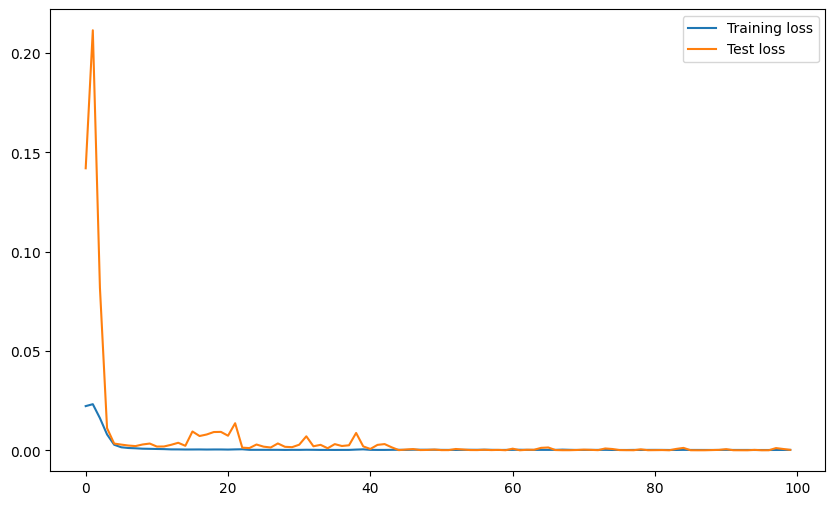

In [40]:
#plotting Train vs Test Loss
plt.figure(figsize=(10, 6))
plt.plot(hist_train, label="Training loss")
plt.plot(hist_test, label="Test loss")
plt.legend()
plt.show()


In [41]:
# Plotting Predictions vs Actual values
from itertools import cycle
import plotly.express as px

# Making Predictions
x_train, y_train = train_loader.dataset.tensors
x_test, y_test = test_loader.dataset.tensors

print("x_train shape:", x_train.size())
print("y_train shape:", y_train.size())
print("x_test shape:", x_test.size())
print("y_test shape:", y_test.size())

x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

with torch.no_grad():
    y_train_pred = model(x_train)
    y_test_pred = model(x_test)
    print("y_train_pred shape:", y_train_pred.size())
    print("y_test_pred shape:", y_test_pred.size())

# Ensure the data is on the CPU to use numpy
y_train_pred = torch.Tensor.cpu(y_train_pred).detach().numpy()
y_test_pred = torch.Tensor.cpu(y_test_pred).detach().numpy()
y_train_original = torch.Tensor.cpu(y_train).detach().numpy()
y_test_original = torch.Tensor.cpu(y_test).detach().numpy()

# Inverse Transform
y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1))
y_train_original = scaler.inverse_transform(y_train_original.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test_original.reshape(-1, 1))

df['Close'] = scaler.inverse_transform(df[['Close']])

# Shift train predictions for plotting
trainPredictPlot = np.empty((len(df), 1))
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred) + lookback, :] = y_train_pred[:len(y_train_pred)]

# Shift test predictions for plotting
testPredictPlot = np.empty((len(df), 1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred) + (lookback):len(df), :] = y_test_pred[:len(y_test_pred)]

print("Original data shape:", df.shape)
print("Train predicted data shape:", trainPredictPlot.shape)
print("Test predicted data shape:", testPredictPlot.shape)

names = cycle(['Original close price', 'Train predicted close price', 'Test predicted close price'])

plotdf = pd.DataFrame({'date': df.index,
                       'original_close': df['Close'],
                       'train_predicted_close': trainPredictPlot.reshape(1, -1)[0].tolist(),
                       'test_predicted_close': testPredictPlot.reshape(1, -1)[0].tolist()})



fig = px.line(plotdf, x=plotdf['date'], y=[plotdf['original_close'], plotdf['train_predicted_close'],
                                           plotdf['test_predicted_close']],
              labels={'value': 'Stock price', 'date': 'Date'})
fig.update_layout(title_text='Comparison between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t: t.update(name=next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

x_train shape: torch.Size([2399, 20, 1])
y_train shape: torch.Size([2399, 1])
x_test shape: torch.Size([600, 20, 1])
y_test shape: torch.Size([600, 1])
y_train_pred shape: torch.Size([2399, 1])
y_test_pred shape: torch.Size([600, 1])
Original data shape: (3019, 6)
Train predicted data shape: (3019, 1)
Test predicted data shape: (3019, 1)


In [42]:
#Model Evaluation Metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
#Calculating MSE
train_Score_mse = mean_squared_error(y_train_original, trainPredictPlot[lookback:len(y_train_pred)+lookback])
print('Train Score: %.2f MSE' % (train_Score_mse))
testScore_mse = mean_squared_error(y_test_original, testPredictPlot[len(y_train_pred)+(lookback):len(df)])
print('Test Score: %.2f MSE' % (testScore_mse))
#Calculating RMSE
trainScore_rmse = sqrt(mean_squared_error(y_train_original, trainPredictPlot[lookback:len(y_train_pred)+lookback]))
print('Train Score: %.2f RMSE' % (trainScore_rmse))
testScore_rmse = sqrt(mean_squared_error(y_test_original, testPredictPlot[len(y_train_pred)+(lookback):len(df)]))
print('Test Score: %.2f RMSE' % (testScore_rmse))
#Calculating MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
trainScore_mape = mean_absolute_percentage_error(y_train_original, trainPredictPlot[lookback:len(y_train_pred)+lookback])
print('Train Score: %.2f MAPE' % (trainScore_mape))
testScore_mape = mean_absolute_percentage_error(y_test_original, testPredictPlot[len(y_train_pred)+(lookback):len(df)])
print('Test Score: %.2f MAPE' % (testScore_mape))

#Saving the model
torch.save(model.state_dict(), 'GRU_model.pth')

#Model hyperparameters and layers to a dictinoary
model_hyperparameters = {
                        'lookback': lookback,
                        'hidden_dim': hidden_dim, 
                        'num_layers': num_layers, 
                        'epochs': num_epochs,
                        'learning_rate': alpha,
                        'batch_size': batch_size,
                        'criterion': 'MSELoss',
                        'optimizer': 'Adam',
                        'scheduler': 'ReduceLROnPlateau',
                        'dropout': dropout,
                        'patience': 10
                        }
model_scores = {
                'train_mse': round(train_Score_mse, 2),
                'test_mse': round(testScore_mse, 2),
                'train_rmse': round(trainScore_rmse, 2),
                'test_rmse': round(testScore_rmse, 2),
                'train_mape': round(trainScore_mape, 2),
                'test_mape': round(testScore_mape, 2),
                }

#Printing scores to a file
with open('GRU_scores_smalldataset.txt', 'a') as f:
    f.write('GRU Model\n')
    for key, value in model_hyperparameters.items():
        f.write('%s: %s\n' % (key, value))
    f.write('\n')
    for key, value in model_scores.items():
        f.write('%s: %s\n' % (key, value))
    f.write('--------------------------------\n')
    f.close()



Train Score: 0.10 MSE
Test Score: 0.28 MSE
Train Score: 0.32 RMSE
Test Score: 0.53 RMSE
Train Score: 1.11 MAPE
Test Score: 0.66 MAPE
